In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from clean_data import *
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Data preparing

In [2]:
# convert salary first
data = pd.read_csv("data/data.csv")
data = convert_salary(data)

In [3]:
# divide salary into 5 buckets
def salary_bucket(salary):
    if salary < 50000:
        return '<50,000'
    if salary >= 50000 and salary < 75000:
        return '50,000-75,000'
    elif salary >= 75000 and salary < 100000:
        return '75,000-100,000'
    elif salary >=100000 and salary <= 150000:
        return '10,0000-15,0000'
    else:
        return '>150,000'
    
data['salary_buckets'] = data['salary'].apply(lambda x: salary_bucket(x))

In [4]:
buckets_count = data['salary_buckets'].value_counts()
buckets_count

75,000-100,000     382
50,000-75,000      321
10,0000-15,0000    189
<50,000             36
>150,000            22
Name: salary_buckets, dtype: int64

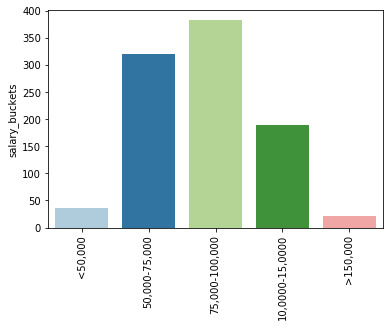

In [5]:
# distribution of classes
sns.barplot(x=buckets_count.index[[3,1,0,2,4]], y=buckets_count[[3,1,0,2,4]], palette="Paired")
plt.xticks(rotation=90)
plt.show()

In [6]:
# split the location into two columns - city and province
# clean the requirement text 
data = clean_location(data)
full_data = clean_requirements(data)

## Model selection including job_category and location

In [7]:
# drop useless columns
mod_data = full_data.drop(columns=['job_title', 'company_name', 'requirements', 'industry', 'requirements_cleaned'])
mod_data = pd.get_dummies(data=mod_data, columns=['job_category','city', 'province'])
mod_data =mod_data.drop(columns=['salary', 'salary_buckets'])

In [8]:
# extract features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
corpus = full_data['requirements_cleaned'].values
grams = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
words_df = pd.DataFrame(grams.toarray(), columns=feature_names)

In [9]:
# split the data
X = pd.concat([mod_data, words_df], axis=1)
Y = full_data['salary_buckets']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=20, test_size=0.3)

In [10]:
# logistic regression
mod_log = LogisticRegression(solver='saga', random_state=33)
c = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 100]
parameters = {'C': c, 'penalty': ['l1', 'l2']}
metric = make_scorer(f1_score, average='weighted')
grid_log = GridSearchCV(mod_log, parameters, scoring=metric, cv=5)
grid_log = grid_log.fit(xtrain, ytrain)
opt_log = grid_log.best_estimator_
print("The optimal logistic regression model: \n", opt_log)
print("====================================================================")
print("The mean accuracy score is {0}.".format(grid_log.best_score_))

The optimal logistic regression model: 
 LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=33, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
The mean accuracy score is 0.5373649154588784.


In [11]:
# KNN
mod_knn = KNeighborsClassifier()
neighbors = np.array(range(5, 50, 5))
parameters = {'n_neighbors': neighbors, 'weights': ['uniform', 'distance']}
metric = make_scorer(f1_score, average='weighted')
grid_knn = GridSearchCV(mod_knn, parameters, scoring=metric, cv=5)
grid_knn = grid_knn.fit(xtrain, ytrain)
opt_knn = grid_knn.best_estimator_
print("The optimal SVM model: \n", opt_knn)
print("====================================================================")
print("The mean accuracy score is {0}.".format(grid_knn.best_score_))

The optimal SVM model: 
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
The mean accuracy score is 0.5764332789520119.


In [12]:
# random forest
mod_rf = RandomForestClassifier(random_state=44)
numTrees = np.array(range(50, 500, 50))
parameters = {'n_estimators': numTrees}
metric = make_scorer(f1_score, average='weighted')
grid_rf = GridSearchCV(mod_rf, parameters, scoring=metric, cv=5)
grid_rf = grid_rf.fit(xtrain, ytrain)
opt_rf = grid_rf.best_estimator_
print("The optimal random forest model: \n", opt_rf)
print("====================================================================")
print("The mean accuracy score is {0}.".format(grid_rf.best_score_))

The optimal random forest model: 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=44, verbose=0,
                       warm_start=False)
The mean accuracy score is 0.6313832875672533.


In [13]:
score_df = pd.DataFrame(np.array([grid_log.best_score_, grid_knn.best_score_, grid_rf.best_score_]), 
                        columns=['F1 score'],
                        index=['Logistic Regression', 'KNN', 'Random Forest'])
score_df

,F1 score
Logistic Regression,0.537365
KNN,0.576433
Random Forest,0.631383


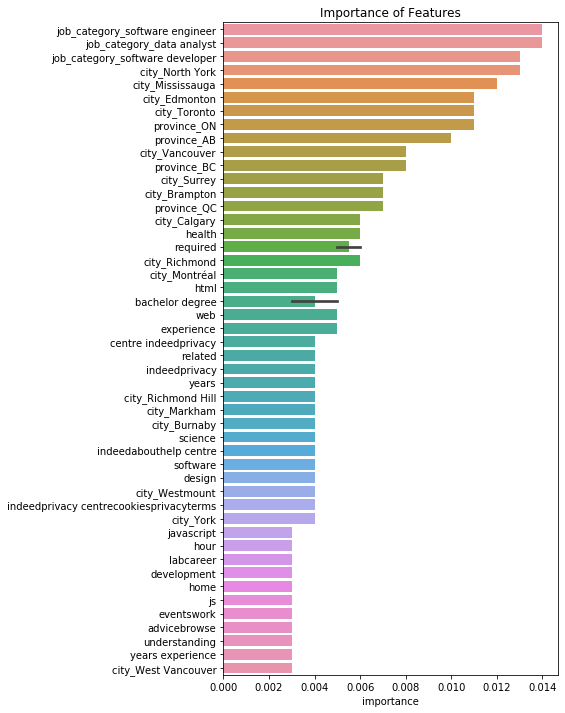

In [14]:
# visualize feature importance based on bag of wrods
# create feature importance data frame
df = pd.DataFrame(opt_rf.feature_importances_, columns=["importance"],
                  index=X.columns)
# sort by importance
df = df.sort_values('importance', ascending=False)
# plot top 20 features
plt.figure(figsize = (6,12))
sns.barplot(x=np.round(df.importance, 3)[0:50], y=df.index[0:50])
plt.title("Importance of Features")
plt.show()

In [15]:
print("The weighted macro f1 socre of the optimal random forest model is", 
      f1_score(ytest, opt_rf.predict(xtest), average='weighted'), ".")

The weighted macro f1 socre of the optimal random forest model is 0.6373526143040409 .


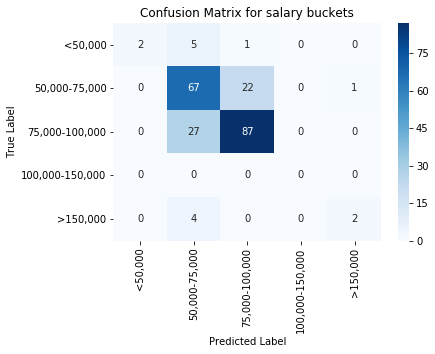

In [16]:
# bulid a confusion matrix
cm = confusion_matrix(ytest, opt_rf.predict(xtest), 
                      labels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'])
# plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
            xticklabels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'], 
            yticklabels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for salary buckets")
plt.show()

## Model selection excluding job_category and location

In [17]:
# when job_category and location are excluded
mod_data = full_data.drop(columns=['job_title', 'company_name', 'requirements', 'industry', 'requirements_cleaned'])
mod_data = mod_data.drop(columns=['job_category', 'city', 'province'])
mod_data =mod_data.drop(columns=['salary', 'salary_buckets'])

In [18]:
# split the data
X = pd.concat([mod_data, words_df], axis=1)
Y = full_data['salary_buckets']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=20, test_size=0.3)

In [20]:
# logistic regression
mod_log = LogisticRegression(solver='saga', random_state=33)
c = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 100]
parameters = {'C': c, 'penalty': ['l1', 'l2']}
metric = make_scorer(f1_score, average='weighted')
grid_log = GridSearchCV(mod_log, parameters, scoring=metric, cv=5)
grid_log = grid_log.fit(xtrain, ytrain)
opt_log = grid_log.best_estimator_
print("The optimal logistic regression model: \n", opt_log)
print("====================================================================")
print("The mean accuracy score is {0}.".format(grid_log.best_score_))

The optimal logistic regression model: 
 LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=33, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
The mean accuracy score is 0.54487052201427.


In [21]:
# KNN
mod_knn = KNeighborsClassifier()
neighbors = np.array(range(5, 50, 5))
parameters = {'n_neighbors': neighbors, 'weights': ['uniform', 'distance']}
metric = make_scorer(f1_score, average='weighted')
grid_knn = GridSearchCV(mod_knn, parameters, scoring=metric, cv=5)
grid_knn = grid_knn.fit(xtrain, ytrain)
opt_knn = grid_knn.best_estimator_
print("The optimal SVM model: \n", opt_knn)
print("====================================================================")
print("The mean accuracy score is {0}.".format(grid_knn.best_score_))

The optimal SVM model: 
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='distance')
The mean accuracy score is 0.601884924133993.


In [22]:
# random forest
mod_rf = RandomForestClassifier(random_state=44)
numTrees = np.array(range(50, 500, 50))
parameters = {'n_estimators': numTrees}
metric = make_scorer(f1_score, average='weighted')
grid_rf = GridSearchCV(mod_rf, parameters, scoring=metric, cv=5)
grid_rf = grid_rf.fit(xtrain, ytrain)
opt_rf = grid_rf.best_estimator_
print("The optimal random forest model: \n", opt_rf)
print("====================================================================")
print("The mean accuracy score is {0}.".format(grid_rf.best_score_))

The optimal random forest model: 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=450,
                       n_jobs=None, oob_score=False, random_state=44, verbose=0,
                       warm_start=False)
The mean accuracy score is 0.6186123006995156.


In [26]:
score_df = pd.DataFrame(np.array([grid_log.best_score_, grid_knn.best_score_, grid_rf.best_score_]), 
                        columns=['F1 score'],
                        index=['Logistic Regression', 'KNN', 'Random Forest'])
score_df

,F1 score
Logistic Regression,0.544871
KNN,0.601885
Random Forest,0.618612


In [23]:
print("The weighted macro f1 socre of the optimal random forest model is", 
      f1_score(ytest, opt_rf.predict(xtest), average='weighted'), ".")

The weighted macro f1 socre of the optimal random forest model is 0.6689319601005596 .


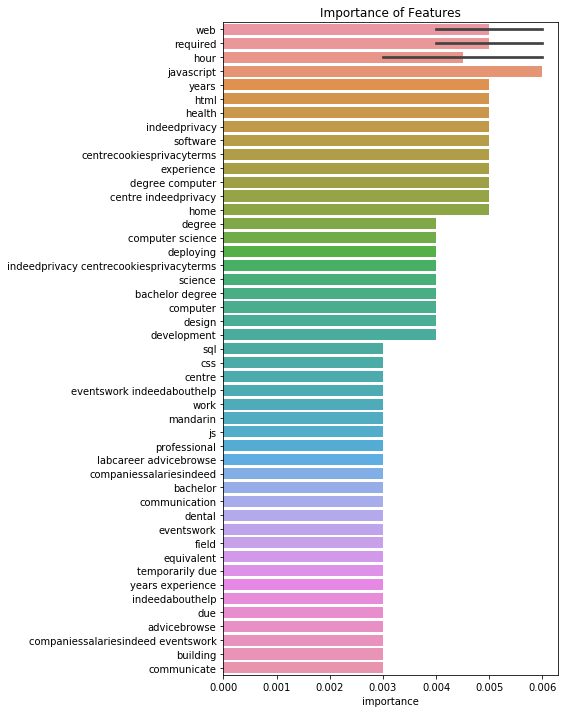

In [24]:
# visualize feature importance based on bag of wrods
# create feature importance data frame
df = pd.DataFrame(opt_rf.feature_importances_, columns=["importance"],
                  index=X.columns)
# sort by importance
df = df.sort_values('importance', ascending=False)
# plot top 20 features
plt.figure(figsize = (6,12))
sns.barplot(x=np.round(df.importance, 3)[0:50], y=df.index[0:50])
plt.title("Importance of Features")
plt.show()

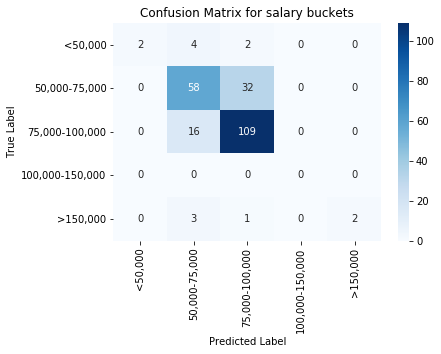

In [25]:
# bulid a confusion matrix
cm = confusion_matrix(ytest, opt_rf.predict(xtest), 
                      labels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'])
# plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
            xticklabels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'], 
            yticklabels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for salary buckets")
plt.show()